In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline



In [2]:
# 1. Load your data (Assuming your dataframe is called 'df')
df = pd.read_csv("D:/New_folder/DBDA/BigDataShared/churn_data.csv")
df.drop(columns=['apartment'], inplace=True)
df = df.dropna()

# 2. Date Feature Engineering
# Convert 'last_tx_date' to a numerical feature: "Days since last transaction"
# This is usually a very strong predictor for churn.
df['last_tx_date'] = pd.to_datetime(df['last_tx_date'])
reference_date = df['last_tx_date'].max()
df['days_since_last_tx'] = (reference_date - df['last_tx_date']).dt.days

# 3. Drop Columns
# - IDs: unique to every row, no predictive power.
# - Address/Lat/Long: High noise for a small dataset (2000 rows).
# - Birth info: Redundant because we have 'current_age'.
cols_to_drop = [
    'user_id', 'person_id', 'birth_year', 'birth_month', 
    'address', 'zipcode', 'latitude', 'longitude', 
    'last_tx_date', 'city' # City might have too many unique values for 2000 rows
]
df_clean = df.drop(columns=cols_to_drop)

# 4. separate features (X) and target (y)
X = df_clean.drop('is_churned', axis=1)
y = df_clean['is_churned']

print(len(df))






1999


####  Preprocessing & Handling Imbalance

In [3]:
# Define which columns are categorical and which are numerical
categorical_cols = ['gender', 'state']
numerical_cols = [col for col in X.columns if col not in categorical_cols]

# Create Transformers
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

#### Building the Pipeline

In [4]:
# Define the model with class_weight='balanced' as an extra safety measure
model = RandomForestClassifier(
    n_estimators=200, 
    random_state=42, 
    class_weight='balanced', # Helps penalize mistakes on the minority class
    max_depth=10 # Prevents the model from memorizing the data
)

# Create the full pipeline: Preprocess -> SMOTE -> Model
clf = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy=0.5)), # Upsample minority to 50% of majority
    ('classifier', model)
])

#### Training and Evaluation

In [5]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train
clf.fit(X_train, y_train)

# Predict
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# Evaluate
print("--- Confusion Matrix ---")
print(confusion_matrix(y_test, y_pred))
print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_test, y_prob):.2f}")

--- Confusion Matrix ---
[[387   0]
 [  0  13]]

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       387
           1       1.00      1.00      1.00        13

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

ROC-AUC Score: 1.00


In [6]:
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, recall_score, precision_score

# 1. Define the CV strategy (5 splits is good for 2000 rows)
# This ensures every churner gets used in testing at some point.
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 2. Define the metrics you care about
scorers = {
    'recall': make_scorer(recall_score),
    'precision': make_scorer(precision_score),
    'f1': 'f1'
}

# 3. Run Cross-Validation
# Note: X and y must be your full dataset (before the train_test_split)
recalls = cross_val_score(clf, X, y, cv=cv, scoring='recall')
precisions = cross_val_score(clf, X, y, cv=cv, scoring='precision')
f1s = cross_val_score(clf, X, y, cv=cv, scoring='f1')

# 4. Print the REAL performance
print(f"Average Recall:    {recalls.mean():.2f} (+/- {recalls.std() * 2:.2f})")
print(f"Average Precision: {precisions.mean():.2f}")
print(f"Average F1 Score:  {f1s.mean():.2f}")

Average Recall:    0.97 (+/- 0.08)
Average Precision: 1.00
Average F1 Score:  0.98


--- Top 5 Threshold Options ---
      Threshold  Precision  Recall
1672   0.218941   0.807692     1.0
1673   0.219293   0.818182     1.0
1674   0.222266   0.828947     1.0
1675   0.227641   0.840000     1.0
1676   0.235759   0.851351     1.0


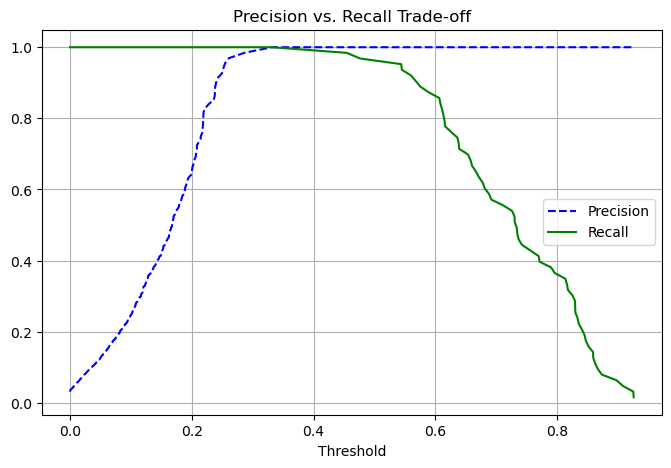

In [7]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 1. Get the probability scores for the positive class (Churn) across all folds
# This mimics how the model behaves on unseen data
y_scores = cross_val_predict(clf, X, y, cv=5, method='predict_proba')[:, 1]

# 2. Calculate Precision and Recall for different thresholds
precisions, recalls, thresholds = precision_recall_curve(y, y_scores)

# 3. Create a DataFrame to verify the best threshold

threshold_df = pd.DataFrame({
    'Threshold': thresholds,
    'Precision': precisions[:-1],
    'Recall': recalls[:-1]
})

# Filter for "Safe" Precision (e.g., at least 80% accurate)
# Sort by Recall to find the highest catch-rate
optimal_options = threshold_df[threshold_df['Precision'] >= 0.80].sort_values(by='Recall', ascending=False)

print("--- Top 5 Threshold Options ---")
print(optimal_options.head(5))

# 4. Visualize the Trade-off (Optional but helpful)
plt.figure(figsize=(8, 5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
plt.xlabel("Threshold")
plt.legend(loc="best")
plt.title("Precision vs. Recall Trade-off")
plt.grid(True)
plt.show()

In [8]:
# 1. Define your optimized threshold
OPTIMAL_THRESHOLD = 0.23

# 2. Get probabilities for new data
# (Assuming X_new is your new incoming data)
probs = clf.predict_proba(X_test)[:, 1] # Use X_test here to verify, change to new data later

# 3. Apply the threshold
# If prob > 0.31, treat as Churn (1), otherwise No Churn (0)
final_predictions = (probs >= OPTIMAL_THRESHOLD).astype(int)

# 4. Quick verification
from sklearn.metrics import classification_report
print(classification_report(y_test, final_predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       387
           1       0.87      1.00      0.93        13

    accuracy                           0.99       400
   macro avg       0.93      1.00      0.96       400
weighted avg       1.00      0.99      1.00       400



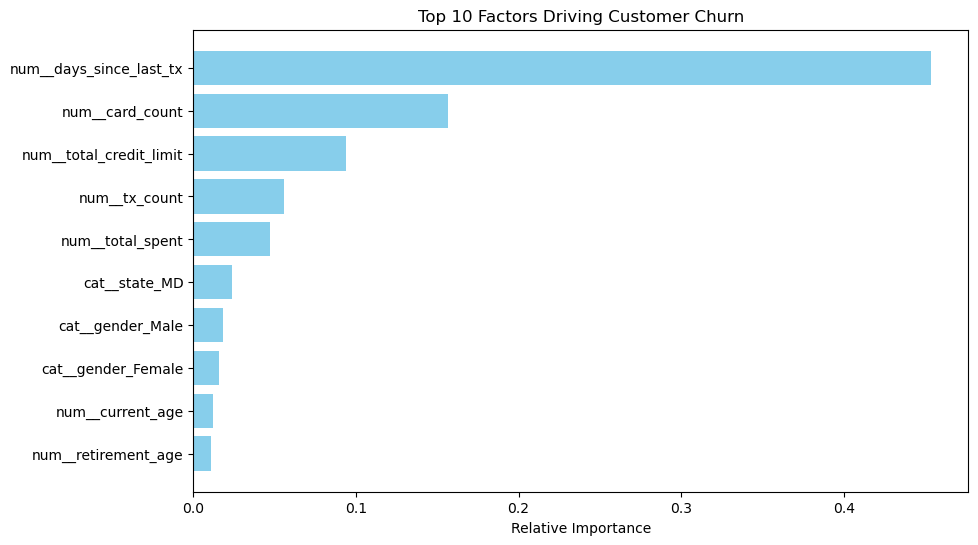

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Get feature names from the preprocessor
# We need to handle the OneHotEncoder adding new columns for states/gender
feature_names = (clf.named_steps['preprocessor']
                 .get_feature_names_out())

# 2. Get importance scores from the Random Forest
importances = clf.named_steps['classifier'].feature_importances_

# 3. Create a DataFrame to organize them
feat_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# 4. Sort and Plot Top 10
feat_df = feat_df.sort_values(by='Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
plt.barh(feat_df['Feature'], feat_df['Importance'], color='skyblue')
plt.gca().invert_yaxis() # Put the most important at the top
plt.title('Top 10 Factors Driving Customer Churn')
plt.xlabel('Relative Importance')
plt.show()